Bachelor thesis Data Mining
Bielefeld University
Lukas Wüppelmann

## Data set
The file `partial_credit_data` contains Data of of students and tasks where every column represents a student and every row a task with possible point range [0,3]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# our data set models a fictional class of students completing a
# number of tasks and is samples from a ground truth 2-PL IRT model
# BUT with a twist, namely that the ground truth ability is actually
# two-dimensional, not uni-dimensional. Still, the abilities are
# correlated, so that a uni-dimensional construct can cover the data
# quite well.

N = 100

# here is our Q matrix
Q = np.array([
   [2., 0.],
   [0., 2.],
   [1., 0.2],
   [0.2, 1.],
   [1., 0.5],
   [0.5, 1.],
   [1., 1.]
])

# here our difficulties for each achievable point value
B = np.array([
   [-1., 0., 2.],
   [-1., 0., 2.],
   [-1, 0.5, 1.5],
   [-1, 0.5, 1.5],
   [0.7, 1., 2.],
   [0.7, 1., 2.],
   [0.5, 1.5, 1.8]
])


A = 4

abilities = np.random.randn(N, 2)

# compute the logit success probabilities of every student on every task
Z = np.zeros((N, B.shape[0], B.shape[1] + 1))
for i in range(N):
   Z[i, :, 1:] = (np.expand_dims(np.dot(abilities[i, :], Q.T), 1) - B) * A

Z = np.cumsum(Z, axis = 2)

# compute probabilities
P = np.exp(Z) / np.expand_dims(np.sum(np.exp(Z), axis = 2), 2)

# sample actual data
X = np.zeros((N, B.shape[0]))
for i in range(N):
   for j in range(B.shape[0]):
     X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)

np.savetxt('partial_credit_data.csv', X, fmt = '%g', delimiter = '\t',
encoding = 'utf-8')

C:\Users\wuepp\AppData\Local\Temp\ipykernel_15828\2809394630.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i, j] = np.random.choice(B.shape[1]+1, p = P[i, j, :], size = 1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

X = np.loadtxt('partial_credit_data.csv', delimiter = '\t', dtype=int)

# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

print("number of students: " + str(N))
print("number of tasks: " + str(m))

[[1 2 1 2 0 1 1]
 [2 2 2 1 1 0 1]
 [2 2 1 1 0 0 0]
 [2 1 1 2 1 2 1]
 [0 2 1 2 0 1 0]
 [0 0 1 0 0 0 0]
 [1 1 1 1 0 0 0]
 [3 1 2 1 2 0 1]
 [0 2 1 2 0 1 1]
 [0 0 0 0 0 0 0]
 [2 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [1 1 1 1 0 0 0]
 [2 0 1 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 2 0 1 0 0 0]
 [3 3 3 2 3 3 3]
 [1 0 1 0 0 0 0]
 [2 2 2 2 0 0 1]
 [1 0 1 0 0 0 0]
 [0 1 0 1 0 0 0]
 [0 3 1 2 0 0 1]
 [2 0 1 0 0 0 0]
 [2 2 2 1 0 0 1]
 [0 0 0 0 0 0 0]
 [2 3 3 3 2 3 3]
 [1 2 1 1 0 0 0]
 [0 1 1 1 0 0 0]
 [1 0 1 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 3 1 2 0 1 1]
 [2 0 1 0 0 0 0]
 [3 2 2 2 2 1 2]
 [0 3 1 3 0 2 1]
 [2 0 1 1 0 0 0]
 [2 2 2 1 2 2 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 2 1 1 0 0 0]
 [2 2 1 1 0 0 0]
 [1 3 1 2 0 1 2]
 [1 3 1 3 2 3 3]
 [2 0 1 0 0 0 0]
 [2 1 1 1 0 0 0]
 [0 3 1 3 0 2 2]
 [0 0 0 1 0 0 0]
 [2 1 1 1 3 0 1]
 [1 0 1 0 0 0 0]
 [3 1 2 1 2 0 1]
 [1 0 2 0 0 0 0]
 [0 3 1 3 0 1 0]
 [0 2 1 1 0 0 0]
 [2 0 1 1 0 0 0]
 [2 1 2 1 0 0 1]
 [0 2 0 1 0 0 0]
 [2 1 2 1 0 0 0]
 [2 1 2 1 1 0 2]
 [2 0 1 0 0 0 

## Pytorch setup

In [5]:
%pip install torch


  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.8/199.4 MB 17.0 MB/s eta 0:00:12
   ---------------------------------------- 2.1/199.4 MB 22.4 MB/s eta 0:00:09
    --------------------------------------- 3.4/199.4 MB 24.1 MB/s eta 0:00:09
    --------------------------------------- 3.7/199.4 MB 19.9 MB/s eta 0:00:10
   - -------------------------------------- 6.0/199.4 MB 25.6 MB/s eta 0:00:08
   - -------------------------------------- 7.3/199.4 MB 25.8 MB/s eta 0:00:08
   - -------------------------------------- 8.6/199.4 MB 26.1 MB/s eta 0:00:08
   - -------------------------------------- 9.9/199.4 MB 26.2 MB/s eta 0:00:08
   -- ------------------------------------- 11.1/199.4 MB 27.3 MB/s eta 0:00:07
   -- ------------------------------------- 12.3/199.4 MB 27.3 MB/s eta 0:00:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import torch

class IRTModel(torch.nn.Module):
    """The initialization method of a pytorch module. Here, we should set all hyperparameters
    of the model, such as the regularization strength.

    Parameters
    ----------
    C: float (default = 1000)
        The inverse of the L2 regularization strength.
    num_epochs: int (default = 1000)
        How many times we iterate over the data set during training.
    learning_rate: float (default = 1E-2)
        The learning rate of our optimizer during training.
    """
    def __init__(self, C = 1000, num_epochs = 1000, learning_rate = 1E-2):
        # We call the torch.nn.Module constructor
        super(IRTModel, self).__init__()
        # Then, we store all hyperparameters as attributes of the model
        self.C_ = C
        self.num_epochs_ = num_epochs
        self.learning_rate_ = learning_rate

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Z: torch.tensor
        A matrix where each row represents a student and each column represents a task.
        The entry Z[i, j] represents the logit probability of student i passing task j.
    
    """
    def predict_logits(self, X = None):
        # the logits correspond to the difference of abilities and difficulties.
        # The 'unsqueeze' method transforms the abilities vector from an N-entry
        # vector to an (N, 1)-matrix and the difficulties vector from an m-entry
        # vector to an (1, m)-matrix, such that the difference - thanks to the
        # magic of broadcasting - yields a (N, m) matrix.
        Z = self.abilities_.unsqueeze(1) - self.difficulties_.unsqueeze(0)
        return Z

    """Predicts responses based on the learned parameters.
    
    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    Returns
    -------
    Xhat: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry Xhat[i, j] is 1 if the model predicts student i to pass task j and 0
        otherwise.
    
    """
    def predict(self, X = None):
        Z = self.predict_logits()
        Xhat = torch.zeros_like(Z)
        Xhat[Z > 0.] = 1.
        return Xhat.detach().numpy()

    """Fits this model to the given data matrix.

    Parameters
    ----------
    X: np.ndarray
        A matrix where each row represents a student and each column represents a task.
        The entry X[i, j] is expected to be 0 if student i failed task j and to be 1
        if student i passed task j.

    """
    def fit(self, X):
        # convert the input matrix to a pytorch tensor
        X = torch.tensor(X, dtype=torch.float)
        # initialize our model parameters based on passing rates, meaning:
        # students have higher initial ability if they get more tasks right and
        # items have higher initial difficulty if less students get them right.
        self.abilities_    = torch.nn.Parameter(torch.mean(X, 1).detach() - 0.5)
        self.difficulties_ = torch.nn.Parameter(0.5 - torch.mean(X, 0).detach())
        # initialize optimizer with the right learning rate and regularization strength
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate_, weight_decay=1./self.C_)
        # start training
        for epoch in range(self.num_epochs_):
            # re-set the current gradient to zero
            optimizer.zero_grad()
            # predict the logit passing probabilities for each student-item combination
            # with the current model
            Z = self.predict_logits()
            # compute the loss between predicted and desired answers using the crossentropy loss
            loss = torch.nn.functional.binary_cross_entropy_with_logits(Z, X)
            # report the loss every 100 steps
            if (epoch+1) % 100 == 0:
                print('epoch %d: loss %g' % (epoch+1, loss.item()))
            # compute the gradient
            loss.backward()
            # apply the optimizer
            optimizer.step()
        
        return self

## training

In [83]:
model_pytorch = IRTModel()
model_pytorch.fit(X)
Xhat = model_pytorch.predict(X)
accuracy = np.mean(Xhat == X)
print(f'Accuracy: {accuracy:.2f}')
print(Xhat)


epoch 100: loss -0.901313
epoch 200: loss -1.39042
epoch 300: loss -1.79679
epoch 400: loss -2.14637
epoch 500: loss -2.45288
epoch 600: loss -2.72582
epoch 700: loss -2.97245
epoch 800: loss -3.19838
epoch 900: loss -3.40794
epoch 1000: loss -3.60444
Accuracy: 0.43
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


## VAE

### Models

In [25]:
import torch
import torch.nn.functional as F

class VAE(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories):
        super(VAE, self).__init__()
        self.num_categories = num_categories
        self.n_ = num_latent
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        self.dec2 = torch.nn.Linear(num_neurons, num_inputs)

    def forward(self, X):
        # Encoding
        H_enc = torch.nn.functional.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.n_]
        LogSigma = Mu_and_LogSigma[:, self.n_:]
        # Sampling
        Z = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)
        # Decoding
        H_dec = torch.nn.functional.relu(self.dec1(Z))
        Y = self.dec2(H_dec)
        # Scaling the output to 0-3 range
        Y = torch.sigmoid(Y) * (self.num_categories - 1)
        return Mu, LogSigma, Z, Y

    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 10000
        lambda_ = 0.1
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # Start training
        for epoch in range(num_epochs):
            # Reset the current gradient to zero
            optimizer.zero_grad()
            # Autoencode the data
            Mu, LogSigma, Z, Y = self.forward(X)
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(torch.square(Z))
            neg_log_qzx = torch.sum(LogSigma)
            neg_log_pxz = 0.5 / lambda_ ** 2 * torch.sum(torch.square(X - Y))
            loss = neg_log_pxz + neg_log_pz - neg_log_qzx
            # Compute the gradient via backpropagation
            loss.backward()
            # Apply the optimizer
            optimizer.step()

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

class VAE_PC(torch.nn.Module):
    def __init__(self, num_inputs, num_neurons, num_latent, num_categories, noise = 0.1, regul = 0.1, monotonic_penalty_parameter = 50, q_penalty_parameter = 10):
        super(VAE_PC, self).__init__()
        self.q_penalty_parameter = q_penalty_parameter
        self.monotonic_penalty_parameter = monotonic_penalty_parameter
        self.noise = noise
        self.regul = regul
        self.num_inputs = num_inputs
        self.num_latent = num_latent
        self.num_categories = num_categories
        self.enc1 = torch.nn.Linear(num_inputs, num_neurons)
        self.enc2 = torch.nn.Linear(num_neurons, 2 * num_latent)
        #self.dec1 = torch.nn.Linear(num_latent, num_neurons)
        #self.dec2 = torch.nn.Linear(num_latent, num_inputs)
        # Definiere eine Matrix für Diskriminationsparameter (Q)
        self.Q = torch.nn.Parameter(torch.abs(torch.randn(num_latent, num_inputs)))

        # Diskriminationsparameter und Schwellenwerte initialisieren
        self.a = torch.nn.Parameter(torch.ones(num_inputs))  # Diskriminationsparameter
        #self.a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        self.b = torch.nn.Parameter(torch.randn(num_inputs, num_categories - 1))  # Schwellenwerte
        #self.b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing

    def forward(self, X):
        # Encoding
        H_enc = torch.relu(self.enc1(X))
        Mu_and_LogSigma = self.enc2(H_enc)
        Mu = Mu_and_LogSigma[:, :self.num_latent]
        LogSigma = Mu_and_LogSigma[:, self.num_latent:]
        # Sampling
        # eventuell noise parameter 10e-2
        theta = Mu + torch.exp(LogSigma) * torch.randn_like(Mu)*self.noise
        # Decoding
        #H_dec = torch.relu(self.dec1(Z))
        
        #raw_logits = self.dec2(theta)  # Fähigkeitsschätzung
        #nich constrainter layer bis jetzt
        #print(raw_logits)

        #Apply softplus to ensure Q is positive
        #learned_Q = torch.nn.functional.softplus(self.Q)
        
        #Apply ReLU
        #learned_Q = torch.relu(self.Q)

        # Matrix-basiertes Decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrixmultiplikation

        # Initialisiere eine leere Liste für die Logits (logarithmischen Wahrscheinlichkeiten)
        logits = []

        #a_pos = torch.exp(self.a)  # Exponentiation ensures positivity
        #b_aufsteigend = torch.cumsum(torch.cat([self.b[:, :1], F.softplus(self.b[:, 1:])], dim=1), dim=1)  # Ensure b is monotonically increasing
        
        # Schleife über die Anzahl der Inputs (Items im Test)
        for i in range(self.num_inputs):
            # Initialisiere eine leere Liste für die Logits eines einzelnen Items
            item_logits = []
            
            # Schleife über die Kategorien des aktuellen Items
            for k in range(self.num_categories):
                if k == 0:
                    # Für die erste Kategorie (k = 0) setzen wir die Logits auf Null
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Berechne die Logits für die restlichen Kategorien
                    # Die Logits sind kumulativ, d.h., sie basieren auf den vorherigen Logits
                    item_logits.append((raw_logits[:, i] - self.b[i, k-1]) * self.a[i] + item_logits[-1])
            
            # Füge die Logits des aktuellen Items zur Liste hinzu, und stacke sie entlang der letzten Dimension
            logits.append(torch.stack(item_logits, dim=-1))

        # Stacke die Logits aller Items entlang der zweiten Dimension
        logits = torch.stack(logits, dim=1)
        # Wende die Softmax-Funktion auf die Logits an, um die Wahrscheinlichkeitsverteilung über die Kategorien zu erhalten
        Y = torch.softmax(logits, dim=-1)

        # Gib die anderen Variablen und die Wahrscheinlichkeiten zurück
        return Mu, LogSigma, theta, Y
    
    def decode(self, theta):
        # Decoding only
        # Matrix-based decoding
        raw_logits = torch.matmul(theta, self.Q)  # Matrix multiplication

        # Initializing an empty list for logits
        logits = []

        # Loop over the number of inputs (tasks)
        for i in range(self.num_inputs):
            # Initializing an empty list for the logits of a single item
            item_logits = []

            # Loop over categories for the current item
            for k in range(self.num_categories):
                if k == 0:
                    # For the first category (k = 0), set logits to zero
                    item_logits.append(torch.zeros_like(raw_logits[:, i]))
                else:
                    # Calculate logits for remaining categories
                    item_logits.append((raw_logits[:, i] - self.b[i, k - 1]) * self.a[i] + item_logits[-1])

            # Add the logits for the current item to the list
            logits.append(torch.stack(item_logits, dim=-1))

        # Stack logits for all items along the second dimension
        logits = torch.stack(logits, dim=1)
        # Apply softmax to logits to get probabilities
        Y = torch.softmax(logits, dim=-1)

        return Y
    
    
        
        """
        logits = []

        for i in range(self.num_inputs):
            item_logits = []
            
            # Neue Berechnung: raw_logits_item repräsentiert den Einfluss der latenten Fähigkeiten
            raw_logits_item = torch.sum(theta * self.a[i], dim=1)
            
            for k in range(self.num_categories):
                if k == 0:
                    item_logits.append(torch.zeros_like(raw_logits_item))
                else:
                    # Berechne die Logits unter Berücksichtigung der Schwellenwerte b
                    item_logits.append((raw_logits_item - self.b[i, k-1]) + item_logits[-1])
            
            logits.append(torch.stack(item_logits, dim=-1))

        logits = torch.stack(logits, dim=1)
        Y = torch.softmax(logits, dim=-1)

        return Mu, LogSigma, theta, Y
        """



    def fit(self, X):
        # Initialize everything before training
        learning_rate = 1E-3
        num_epochs = 10000
        X = torch.tensor(X, dtype=torch.float)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_values = []
        
        # Start training
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            Mu, LogSigma, theta, Y = self.forward(X)
            
            # Compute the loss function
            neg_log_pz = 0.5 * torch.sum(theta ** 2) * self.regul
            neg_log_qzx = torch.sum(LogSigma) * self.regul
            
            #X_onehot = F.one_hot(X.long(), num_classes=self.num_categories).float()
            #neg_log_pxz = -torch.sum(X_onehot * torch.log(Y + 1e-10))
            
            # Compute negative log-likelihood without one-hot encoding
            # X is assumed to be integer-encoded
            X_int = X.squeeze().to(torch.long)  # Remove unnecessary dimensions if needed
            # Use torch.gather to select the probabilities corresponding to the true classes
            true_probs = torch.gather(Y, dim=-1, index=X_int.unsqueeze(-1)).squeeze(-1)
            neg_log_pxz = -torch.sum(torch.log(true_probs + 1e-10))  # Adding epsilon to avoid log(0)
            
            
            original_loss = neg_log_pxz + neg_log_pz - neg_log_qzx

            # Monotonicity penalty
            diffs = self.b[:, 1:] - self.b[:, :-1]
            mono_penalty = torch.sum(F.relu(-diffs))

            # Penalize negative values in Q

            q_penalty = torch.sum(F.relu(-self.Q))
            
            loss = original_loss + self.monotonic_penalty_parameter * mono_penalty + self.q_penalty_parameter * q_penalty
            loss_values.append(loss.item())
            
            loss.backward()
            optimizer.step()

            if (epoch % 100 == 0):
                print(f"Epoch {epoch}, Loss: {loss.item()}")

        # Plot the loss curve
        plt.plot(loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.show()


### Generated Data

In [26]:
num_inputs = 7  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 4

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

# Calculate accuracy for validation set by comparing with validation input data
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Accuracy on validation set: {accuracy_val}")


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15828\4060701829.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Accuracy: 0.9946428571428572
Accuracy on validation set: 0.8357142857142857


C:\Users\wuepp\AppData\Local\Temp\ipykernel_15828\1360021467.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 1104.440185546875
Epoch 100, Loss: 791.703369140625
Epoch 200, Loss: 665.28662109375
Epoch 300, Loss: 575.8551025390625
Epoch 400, Loss: 520.084716796875
Epoch 500, Loss: 474.2310485839844
Epoch 600, Loss: 439.0404052734375
Epoch 700, Loss: 411.6502685546875
Epoch 800, Loss: 383.66632080078125
Epoch 900, Loss: 361.6497497558594
Epoch 1000, Loss: 341.49786376953125
Epoch 1100, Loss: 326.70782470703125
Epoch 1200, Loss: 314.5904541015625
Epoch 1300, Loss: 304.1466369628906
Epoch 1400, Loss: 292.84027099609375
Epoch 1500, Loss: 283.5403747558594
Epoch 1600, Loss: 274.37164306640625
Epoch 1700, Loss: 264.6543273925781
Epoch 1800, Loss: 254.75137329101562
Epoch 1900, Loss: 244.8417510986328
Epoch 2000, Loss: 237.37745666503906
Epoch 2100, Loss: 231.1422576904297
Epoch 2200, Loss: 221.50018310546875
Epoch 2300, Loss: 213.88232421875
Epoch 2400, Loss: 207.0455322265625
Epoch 2500, Loss: 199.775146484375
Epoch 2600, Loss: 193.01072692871094
Epoch 2700, Loss: 189.50433349609375
E

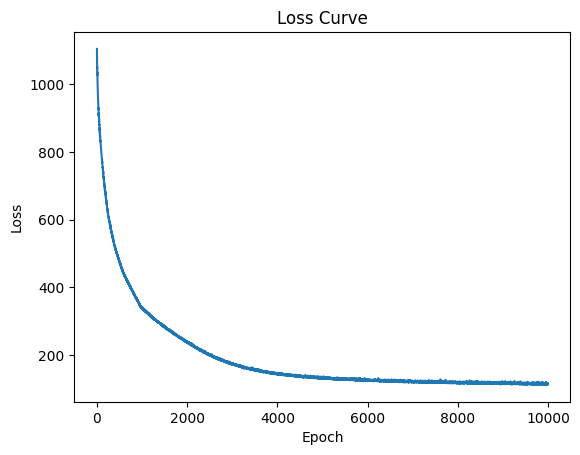

In [28]:
num_inputs = 7  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer


num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=4)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

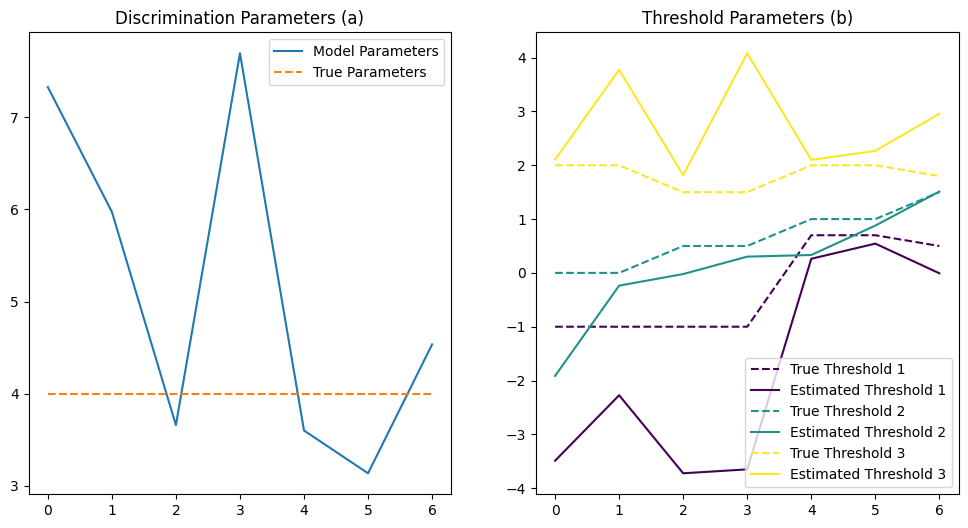

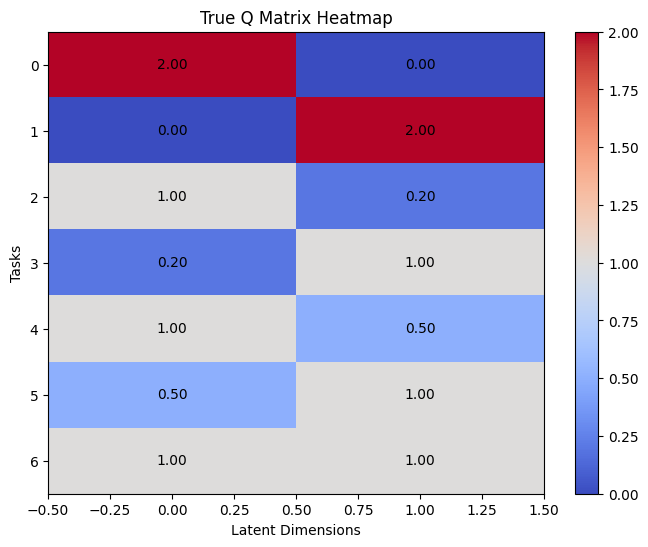

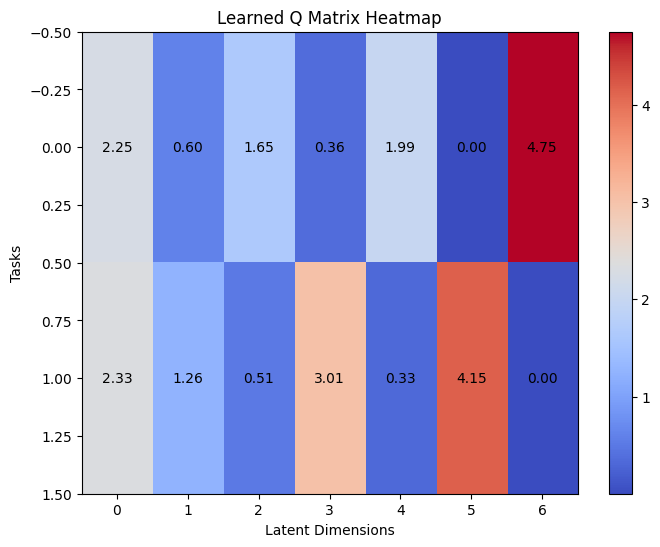

b values:
 [[-3.4899359  -1.913821    2.10608   ]
 [-2.2731616  -0.23660792  3.774116  ]
 [-3.7233922  -0.02124467  1.8180765 ]
 [-3.6507466   0.30195665  4.0810876 ]
 [ 0.26246473  0.33287257  2.099692  ]
 [ 0.5441933   0.87914675  2.2676141 ]
 [-0.00718613  1.5126811   2.9574811 ]]
original B values:
 [[-1.   0.   2. ]
 [-1.   0.   2. ]
 [-1.   0.5  1.5]
 [-1.   0.5  1.5]
 [ 0.7  1.   2. ]
 [ 0.7  1.   2. ]
 [ 0.5  1.5  1.8]]
Differences (should be non-negative):
 []
a values (should be positive):
 [7.327317  5.9736147 3.6591709 7.6933103 3.6010797 3.1370385 4.5351443]
Learned Q matrix:
 [[2.2483697e+00 2.3345373e+00]
 [6.0213917e-01 1.2608087e+00]
 [1.6477586e+00 5.1109320e-01]
 [3.6045122e-01 3.0144646e+00]
 [1.9932315e+00 3.3135903e-01]
 [2.6729116e-03 4.1522088e+00]
 [4.7484174e+00 1.5890655e-03]]
True Q matrix:
 [[2.  0. ]
 [0.  2. ]
 [1.  0.2]
 [0.2 1. ]
 [1.  0.5]
 [0.5 1. ]
 [1.  1. ]]
Difference Q matrix:
 [[ 0.24836969  2.33453727]
 [ 0.60213917 -0.73919129]
 [ 0.6477586   

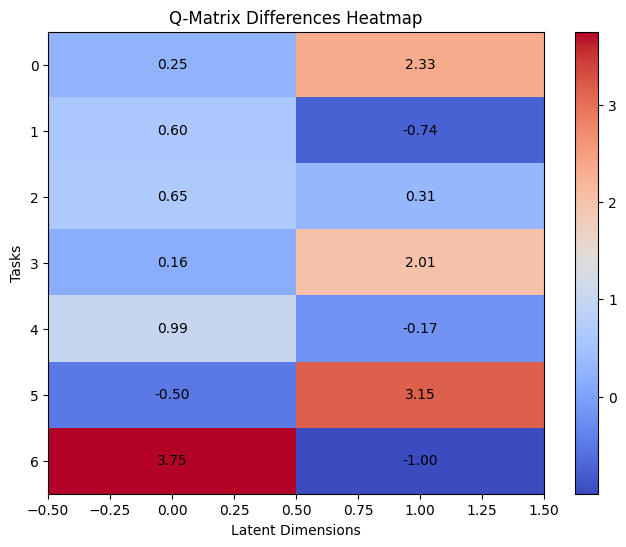

tensor([[-3., -3.]])
tensor([[-2.9394, -2.9394]])
tensor([[-2.8788, -2.8788]])
tensor([[-2.8182, -2.8182]])
tensor([[-2.7576, -2.7576]])
tensor([[-2.6970, -2.6970]])
tensor([[-2.6364, -2.6364]])
tensor([[-2.5758, -2.5758]])
tensor([[-2.5152, -2.5152]])
tensor([[-2.4545, -2.4545]])
tensor([[-2.3939, -2.3939]])
tensor([[-2.3333, -2.3333]])
tensor([[-2.2727, -2.2727]])
tensor([[-2.2121, -2.2121]])
tensor([[-2.1515, -2.1515]])
tensor([[-2.0909, -2.0909]])
tensor([[-2.0303, -2.0303]])
tensor([[-1.9697, -1.9697]])
tensor([[-1.9091, -1.9091]])
tensor([[-1.8485, -1.8485]])
tensor([[-1.7879, -1.7879]])
tensor([[-1.7273, -1.7273]])
tensor([[-1.6667, -1.6667]])
tensor([[-1.6061, -1.6061]])
tensor([[-1.5455, -1.5455]])
tensor([[-1.4848, -1.4848]])
tensor([[-1.4242, -1.4242]])
tensor([[-1.3636, -1.3636]])
tensor([[-1.3030, -1.3030]])
tensor([[-1.2424, -1.2424]])
tensor([[-1.1818, -1.1818]])
tensor([[-1.1212, -1.1212]])
tensor([[-1.0606, -1.0606]])
tensor([[-1., -1.]])
tensor([[-0.9394, -0.9394]])
t

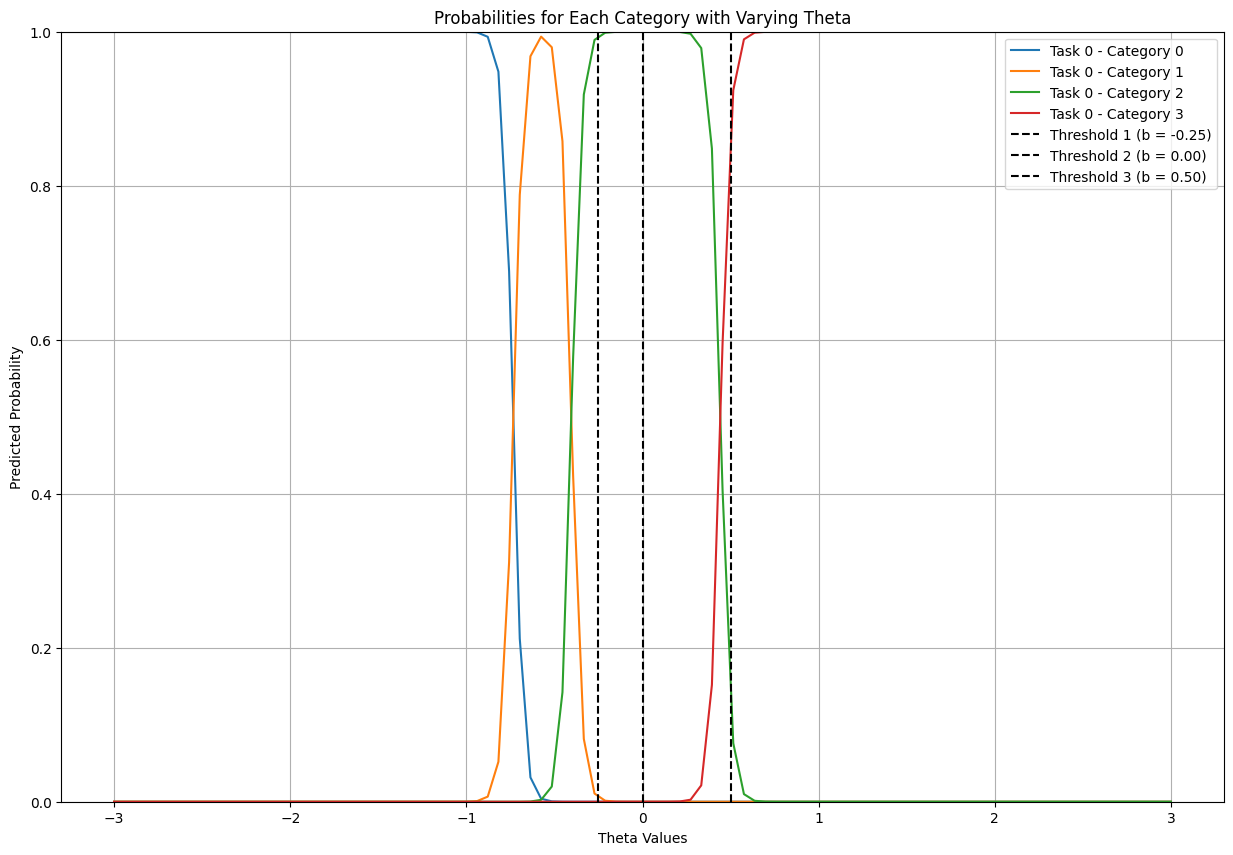

In [30]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(a_values, label='Model Parameters')
plt.plot([A] * len(a_values), label='True Parameters', linestyle='--')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema


# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(B[:, j], label=f'True Threshold {j + 1}', linestyle='--', color=colors[j])  # Echte Werte
    plt.plot(b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Geschätzte Werte

#plt.plot(b_values, label='Model Parameters')
#plt.plot(B, label='True Parameters', linestyle='--')
plt.legend()

plt.show()

learned_Q = model_pytorch.Q.detach().numpy()
learned_Q = learned_Q[:, ::-1]


learned_Q_transposed = learned_Q.T

# Compare the true Q matrix with the learned Q matrix
true_Q = Q

# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(Q, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('True Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        plt.text(j, i, f'{Q[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q.shape[0]):
    for j in range(learned_Q.shape[1]):
        plt.text(j, i, f'{learned_Q[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("original B values:\n", B)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)


if learned_Q_transposed.size == true_Q.size:
    diff_Q = learned_Q_transposed - true_Q
    print("Learned Q matrix:\n", learned_Q_transposed)
    print("True Q matrix:\n", true_Q)
    print("Difference Q matrix:\n", diff_Q)

    # Heatmap erstellen
    plt.figure(figsize=(8, 6))
    plt.imshow(diff_Q, cmap='coolwarm', aspect='auto')

    # Colorbar hinzufügen
    plt.colorbar()

    # Achsenbeschriftungen und Titel
    plt.title('Q-Matrix Differences Heatmap')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Tasks')

    # Zahlenwerte in die Heatmap einfügen
    for i in range(diff_Q.shape[0]):
        for j in range(diff_Q.shape[1]):
            plt.text(j, i, f'{diff_Q[i, j]:.2f}', ha='center', va='center', color='black')

    # Heatmap anzeigen
    plt.show()

else:
    print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[theta_val, theta_val]], dtype=torch.float)
        print(theta_tensor)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



# Define the range of theta values to explore
theta_values = np.linspace(-3,3, 100)  # Adjust the range as needed


# Compute the probabilities for each theta value
probabilities_for_theta = compute_probabilities_for_theta(model_pytorch,theta_values)
# Plotting probabilities against theta values for each task
plt.figure(figsize=(15, 10))

task = 0 #probabilities_for_theta.shape[1]  # Should be 7 tasks

for category in range(model_pytorch.num_categories):
    # Plotting probabilities for each category in this task
    plt.plot(theta_values, probabilities_for_theta[:, task, category], label=f'Task {task} - Category {category}')

b_values_task = B[0,:] / A #b_values[0,:] / a_values[0] 

# Add vertical lines for each threshold (b value)
for j, b_value in enumerate(b_values_task):
    plt.axvline(b_value, color='black', linestyle='--', label=f'Threshold {j + 1} (b = {b_value:.2f})')


plt.title('Probabilities for Each Category with Varying Theta')
plt.xlabel('Theta Values')
plt.ylabel('Predicted Probability')
plt.ylim(0, 1)  # Ensure probabilities are within [0, 1]
plt.legend()  # Legend for tasks and categories
plt.grid(True)



# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Accuracy on validation set: {accuracy_val}")


#print(Xhat)

### Usability Datensatz

In [29]:
import numpy as np

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('main_sheet_sus.csv', skip_header=1, delimiter=',')

X = data[:, 3:13].astype(int)
# Shape der Daten erhalten
N, m = X.shape

# Daten ausgeben
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))


[[1 4 5 4 4 1 2 1 5 1]
 [2 1 5 1 4 2 5 1 4 1]
 [1 2 3 4 4 4 2 2 1 5]
 [4 5 5 4 5 4 4 1 4 5]
 [4 1 4 1 4 1 5 1 4 1]
 [4 1 5 1 4 1 5 1 5 1]
 [4 1 5 1 5 2 5 1 5 2]
 [5 1 5 5 5 1 5 1 5 3]
 [4 2 4 4 5 2 5 1 4 1]
 [4 1 2 2 5 2 5 1 4 2]
 [1 1 5 1 3 1 1 1 5 1]
 [3 1 5 1 5 1 3 1 5 1]
 [1 2 5 1 4 1 4 1 5 4]
 [1 1 5 1 3 1 4 2 4 2]
 [5 1 4 1 5 1 4 1 4 1]
 [1 1 5 1 4 2 4 1 4 2]
 [1 2 4 2 4 2 3 2 4 1]
 [2 1 5 1 5 1 5 2 5 2]
 [1 2 4 1 4 5 4 2 4 2]
 [1 1 4 2 4 3 4 2 4 2]
 [1 1 2 1 2 4 4 1 4 4]
 [2 2 4 2 5 2 4 1 4 2]
 [1 1 5 1 5 2 4 2 4 1]
 [1 1 4 1 4 1 5 1 5 1]
 [4 1 4 1 4 2 5 1 4 4]
 [1 1 4 1 4 1 5 2 4 5]
 [1 1 5 1 4 2 5 2 5 4]
 [1 1 5 1 5 1 5 1 4 1]
 [1 1 5 5 5 1 5 1 3 3]
 [4 1 5 1 5 1 5 1 5 1]
 [2 1 5 1 3 1 4 1 3 1]]
number of rows: 31
number of columns: 10


C:\Users\wuepp\AppData\Local\Temp\ipykernel_21304\2067561475.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 1626.1712646484375
Epoch 100, Loss: 997.790283203125
Epoch 200, Loss: 885.0291748046875
Epoch 300, Loss: 812.068359375
Epoch 400, Loss: 766.1127319335938
Epoch 500, Loss: 735.68408203125
Epoch 600, Loss: 712.5506591796875
Epoch 700, Loss: 692.2511596679688
Epoch 800, Loss: 675.0531616210938
Epoch 900, Loss: 659.8350219726562
Epoch 1000, Loss: 645.9374389648438
Epoch 1100, Loss: 637.0838623046875
Epoch 1200, Loss: 621.2506103515625
Epoch 1300, Loss: 611.9609985351562
Epoch 1400, Loss: 600.170654296875
Epoch 1500, Loss: 591.6426391601562
Epoch 1600, Loss: 583.5706787109375
Epoch 1700, Loss: 574.7138671875
Epoch 1800, Loss: 565.6187744140625
Epoch 1900, Loss: 558.275146484375
Epoch 2000, Loss: 552.7852172851562
Epoch 2100, Loss: 544.5349731445312
Epoch 2200, Loss: 538.678955078125
Epoch 2300, Loss: 532.4905395507812
Epoch 2400, Loss: 526.634765625
Epoch 2500, Loss: 521.88623046875
Epoch 2600, Loss: 517.9293823242188
Epoch 2700, Loss: 513.993896484375
Epoch 2800, Loss: 509.8

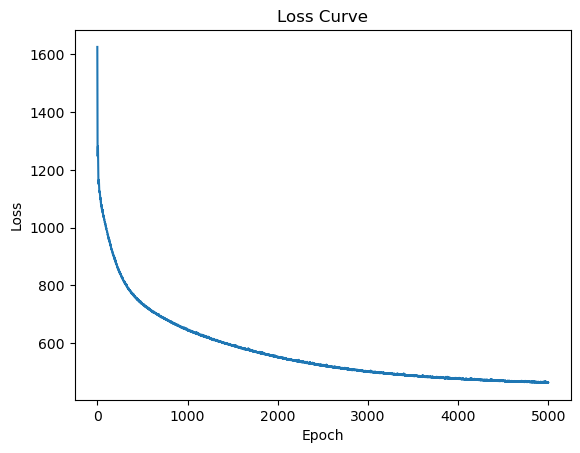

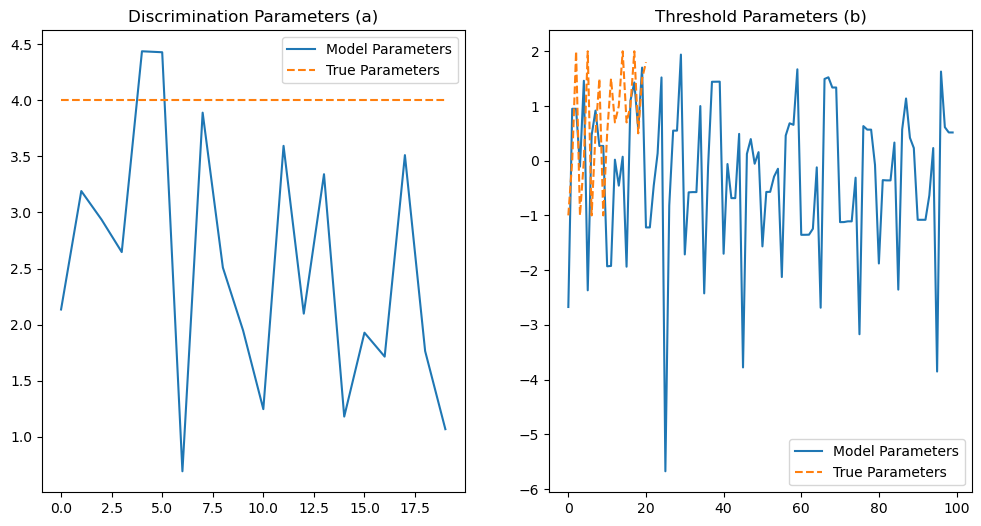

b values:
 [[-2.6742122   0.9488536   0.9486861  -0.1080151   1.4610608 ]
 [-2.3693852   0.46421614  0.91561884  0.26916495  0.26952028]
 [-1.9302453  -1.9238094   0.01825681 -0.45578256  0.07239909]
 [-1.9375262   1.0980864   1.4295775   0.58268344  1.7018182 ]
 [-1.2199651  -1.2198148  -0.45603094  0.13422883  1.5216525 ]
 [-5.6770573  -0.81987065  0.54961944  0.5496249   1.9395075 ]
 [-1.7132891  -0.57835925 -0.57403475 -0.5740524   0.99844366]
 [-2.4253416  -0.10865975  1.4423589   1.443437    1.4448305 ]
 [-1.7004572  -0.06082341 -0.68420815 -0.68449944  0.4901641 ]
 [-3.7788923   0.12398029  0.3953043  -0.05553458  0.15678099]
 [-1.5666349  -0.57119274 -0.5693108  -0.2903688  -0.14724515]
 [-2.1264226   0.45943567  0.6836855   0.6557007   1.6702646 ]
 [-1.3550116  -1.3544567  -1.3524058  -1.2442487  -0.12184692]
 [-2.687441    1.4942759   1.5243862   1.3378012   1.3378375 ]
 [-1.1228538  -1.1219581  -1.1085498  -1.1086555  -0.31049013]
 [-3.1722076   0.632451    0.56804174  0.567

In [64]:
num_inputs = 10  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=6)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

#print(Xhat)

In [10]:
num_inputs = 20  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 6

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")


NameError: name 'VAE' is not defined

### Usability Disability Data set

In [72]:
import numpy as np

# CSV-Datei einlesen (angenommen, die Daten sind Komma-getrennt)
# Anpassen des Delimiters, falls die Daten Tab-getrennt sind: delimiter='\t'
data = np.genfromtxt('usability-data_disability_csv.csv', skip_header=1, delimiter=',')

X = data[:, 51:61].astype(int)
X = np.delete(X, [17], axis=0)
print(X)
# Die Daten in Training und Validierung aufteilen (z.B. 80% Training, 20% Validierung)
X, X_val = train_test_split(X, test_size=0.2, random_state=42)
N, m = X.shape
print(X)

# Anzahl der Zeilen und Spalten ausgeben
print("number of rows: " + str(N))
print("number of columns: " + str(m))


[[0 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 1]
 [3 0 3 0 3 1 4 0 2 0]
 [0 0 3 0 3 1 4 2 2 0]
 [3 0 4 0 4 0 4 0 4 0]
 [4 0 4 1 3 1 4 0 3 0]
 [3 1 2 4 3 1 3 1 3 4]
 [4 0 4 0 4 0 4 0 4 0]
 [1 3 0 2 0 3 2 2 1 1]
 [1 0 3 1 3 1 4 1 3 1]
 [0 2 2 4 2 2 3 2 2 0]
 [3 1 3 1 2 2 3 2 2 1]
 [4 0 2 1 1 0 4 0 3 4]
 [4 4 0 4 4 0 4 0 4 0]
 [1 2 1 3 2 2 2 3 1 3]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 0 4 0 4 0 4 0]
 [3 0 4 1 3 0 4 1 3 0]
 [2 2 1 3 2 2 2 3 1 4]
 [3 2 3 1 2 1 4 2 3 3]
 [4 0 4 0 4 0 4 0 4 0]
 [4 0 4 3 3 0 4 0 4 1]
 [4 0 4 2 4 0 4 0 4 4]
 [0 0 2 0 4 0 4 0 4 0]
 [4 0 4 0 3 0 4 0 4 1]
 [2 0 4 4 4 0 2 0 0 4]
 [2 0 4 3 4 3 4 2 3 1]
 [0 2 1 3 0 4 1 3 1 4]
 [2 0 1 0 1 1 2 0 4 4]
 [1 0 3 0 3 1 3 1 2 1]
 [1 3 2 0 0 2 3 2 3 2]
 [0 1 0 4 1 3 2 4 2 1]
 [1 1 3 0 2 3 3 2 3 3]
 [2 0 4 1 4 0 4 1 3 2]
 [0 0 3 3 2 1 3 2 1 1]
 [0 2 0 2 2 2 0 4 0 3]
 [0 3 2 0 3 2 4 2 2 1]
 [1 0 0 0 1 0 1 2 1 0]
 [1 0 3 0 3 0 3 0 4 1]
 [0 0 4 2 3 1 3 2 1 0]
 [2 0 3 0 3 1 4 0 3 3]
 [2 0 4 0 3 0 4 1 4 0]
 [0 1 3 0 2 1 3 1 4 0]
 [0 1 1 0 0

C:\Users\wuepp\AppData\Local\Temp\ipykernel_10756\1417937527.py:7: RuntimeWarning: invalid value encountered in cast
  X = data[:, 51:61].astype(int)


C:\Users\wuepp\AppData\Local\Temp\ipykernel_10756\1360021467.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Epoch 0, Loss: 2284.98828125
Epoch 100, Loss: 1941.2530517578125
Epoch 200, Loss: 1754.5218505859375
Epoch 300, Loss: 1585.857177734375
Epoch 400, Loss: 1439.382568359375
Epoch 500, Loss: 1311.5501708984375
Epoch 600, Loss: 1205.2557373046875
Epoch 700, Loss: 1122.2293701171875
Epoch 800, Loss: 1056.747314453125
Epoch 900, Loss: 992.919677734375
Epoch 1000, Loss: 936.552978515625
Epoch 1100, Loss: 886.5579223632812
Epoch 1200, Loss: 837.6771850585938
Epoch 1300, Loss: 784.7308349609375
Epoch 1400, Loss: 737.01025390625
Epoch 1500, Loss: 688.1068115234375
Epoch 1600, Loss: 644.6500854492188
Epoch 1700, Loss: 620.672119140625
Epoch 1800, Loss: 595.133056640625
Epoch 1900, Loss: 571.6500854492188
Epoch 2000, Loss: 547.9181518554688
Epoch 2100, Loss: 530.6572875976562
Epoch 2200, Loss: 516.1732788085938
Epoch 2300, Loss: 510.22039794921875
Epoch 2400, Loss: 504.0847473144531
Epoch 2500, Loss: 498.5608215332031
Epoch 2600, Loss: 496.7057800292969
Epoch 2700, Loss: 490.80047607421875
Epoch 2

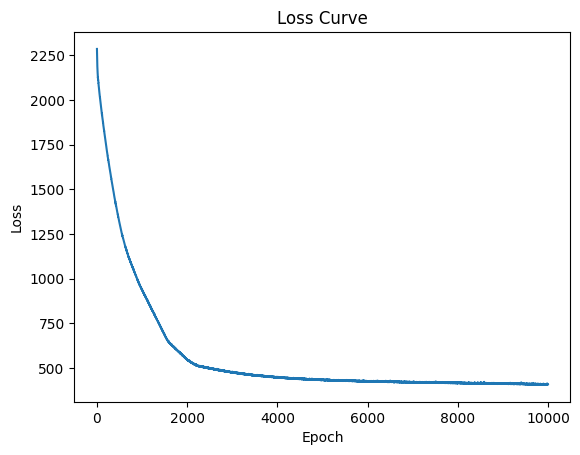

In [77]:
num_inputs = 10  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer

num_latent = 2  # latent space dimension

model_pytorch = VAE_PC(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=6)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

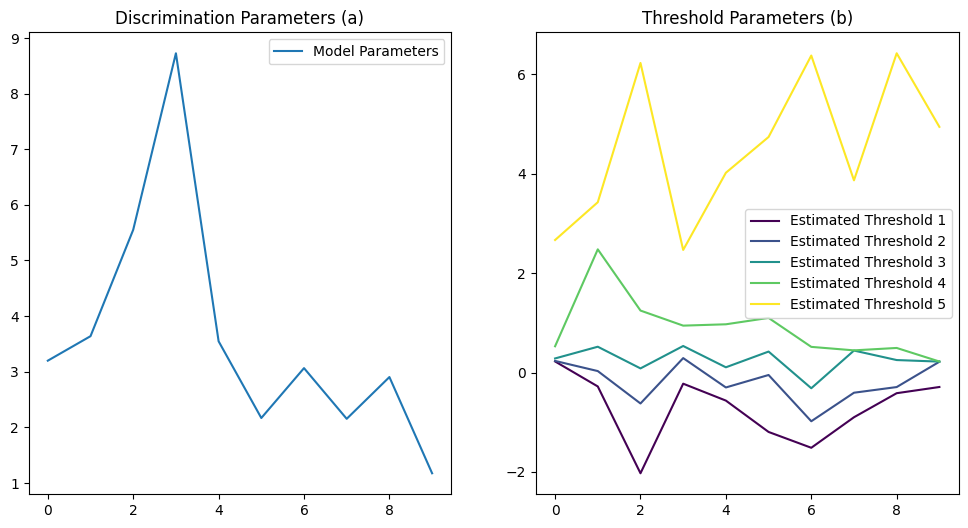

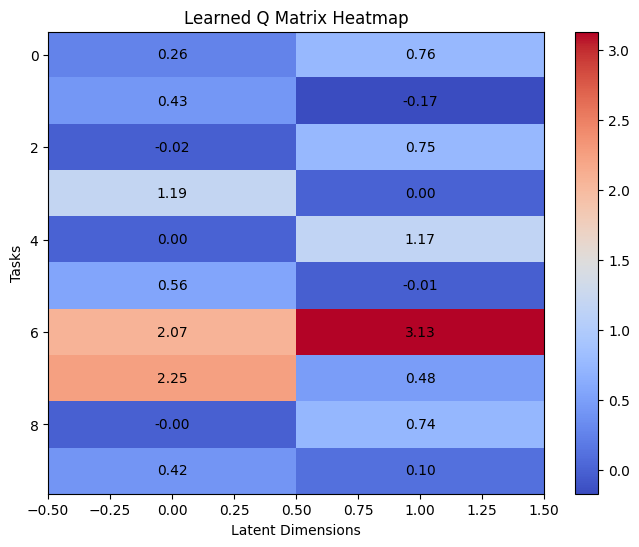

b values:
 [[ 0.22290695  0.2334356   0.28340682  0.52814466  2.6660323 ]
 [-0.27992678  0.02943939  0.5192262   2.4783812   3.4262521 ]
 [-2.0268903  -0.622683    0.08295766  1.2467462   6.2283416 ]
 [-0.22445616  0.2903349   0.53389424  0.9435274   2.4661512 ]
 [-0.5646239  -0.3003696   0.10535392  0.9705079   4.0191755 ]
 [-1.1955274  -0.04957546  0.42165643  1.0988907   4.739054  ]
 [-1.5138853  -0.9801469  -0.31613177  0.5161946   6.377182  ]
 [-0.899471   -0.40618676  0.44206464  0.4460106   3.866853  ]
 [-0.41579008 -0.2922808   0.25102344  0.4944291   6.422962  ]
 [-0.29111046  0.21691096  0.21972632  0.22161968  4.9421344 ]]
Differences (should be non-negative):
 []
a values (should be positive):
 [3.1988032 3.6392024 5.552437  8.725847  3.5473025 2.1678445 3.0648565
 2.1534853 2.904268  1.1741002]
Learned Q matrix:
 [[ 2.6256487e-01  7.5606376e-01]
 [ 4.3302706e-01 -1.6714102e-01]
 [-2.2484934e-02  7.5466937e-01]
 [ 1.1871423e+00  8.1974885e-04]
 [ 5.1446527e-04  1.1724185e+0

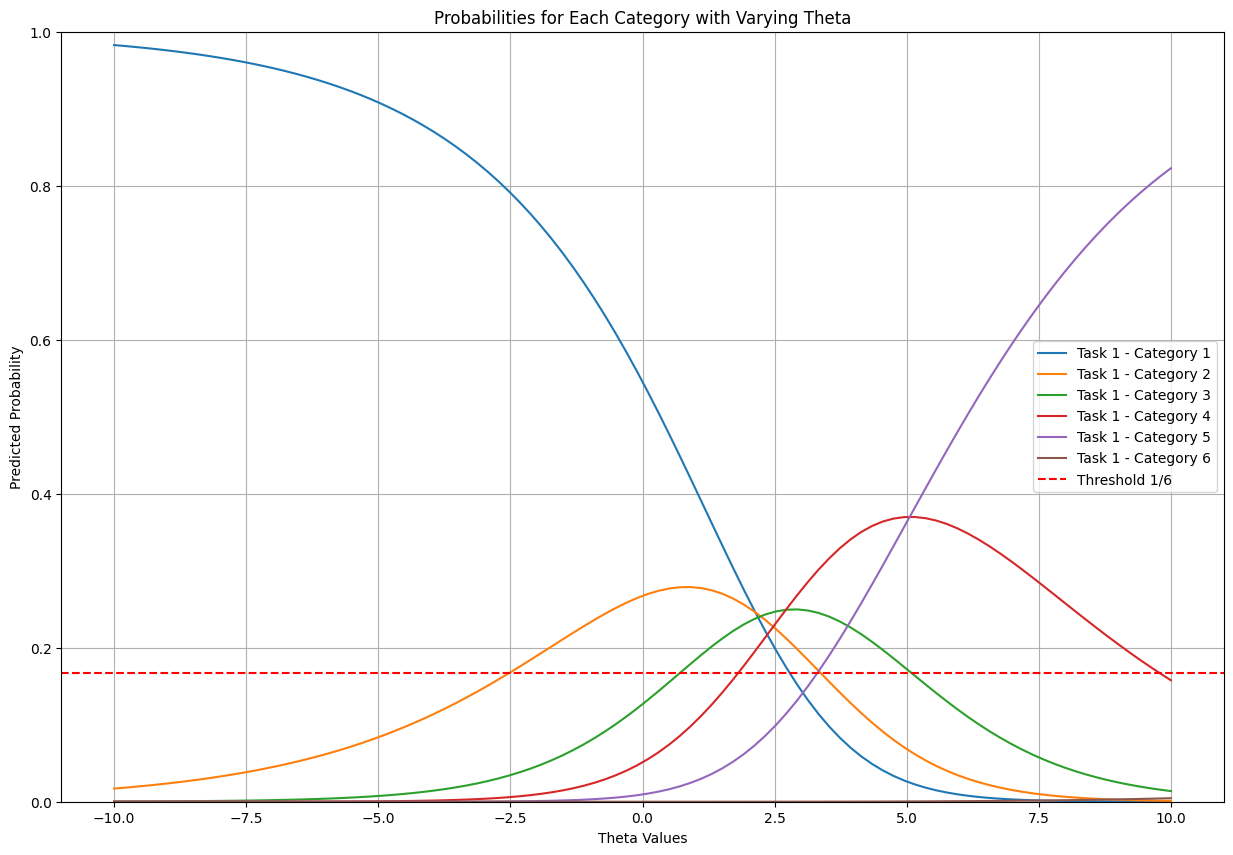

In [79]:
# Extracting model parameters
diffs = model_pytorch.b[:, 1:] - model_pytorch.b[:, :-1]
b_values = model_pytorch.b.detach().numpy()
a_values = model_pytorch.a.detach().numpy()

# Comparing the discrimination parameters (a)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Discrimination Parameters (a)')
plt.plot(a_values, label='Model Parameters')
plt.legend()

# Erstelle eine Liste von Farben für die Parameter
colors = plt.cm.viridis(np.linspace(0, 1, b_values.shape[1]))  # z.B. "viridis" Farbschema


# Comparing the threshold parameters (b)
plt.subplot(1, 2, 2)
plt.title('Threshold Parameters (b)')

# Plotte die echten und geschätzten Werte mit gleichen Farben
for j in range(b_values.shape[1]):  # Für jede Spalte (Parameter)
    plt.plot(b_values[:, j], label=f'Estimated Threshold {j + 1}', color=colors[j])  # Geschätzte Werte

#plt.plot(b_values, label='Model Parameters')
#plt.plot(B, label='True Parameters', linestyle='--')
plt.legend()

plt.show()

learned_Q = model_pytorch.Q.detach().numpy()
learned_Q = learned_Q[:, ::-1]


learned_Q_transposed = learned_Q.T


# Heatmap erstellen
plt.figure(figsize=(8, 6))
plt.imshow(learned_Q_transposed, cmap='coolwarm', aspect='auto')

# Colorbar hinzufügen
plt.colorbar()

# Achsenbeschriftungen und Titel
plt.title('Learned Q Matrix Heatmap')
plt.xlabel('Latent Dimensions')
plt.ylabel('Tasks')

# Zahlenwerte in die Heatmap einfügen
for i in range(learned_Q_transposed.shape[0]):
    for j in range(learned_Q_transposed.shape[1]):
        plt.text(j, i, f'{learned_Q_transposed[i, j]:.2f}', ha='center', va='center', color='black')

# Heatmap anzeigen
plt.show()



neg_diffs = diffs[diffs < 0]

print("b values:\n", b_values)
print("Differences (should be non-negative):\n", neg_diffs.detach().numpy())
print("a values (should be positive):\n", a_values)

print("Learned Q matrix:\n", learned_Q_transposed)

def compute_probabilities_for_theta(model, theta_range):
    probabilities = []

    # Loop through each theta value in the specified range
    for theta_val in theta_range:
        # Create a single latent vector for decoding (shape: (1, num_latent))
        theta_tensor = torch.tensor([[0, theta_val]], dtype=torch.float)
        # Get the probabilities from the model for this theta value
        with torch.no_grad():  # Disable gradient tracking
            Y = model.decode(theta_tensor)  # Forward pass with only theta
        probabilities.append(Y.numpy())

    probabilities = np.array(probabilities)

    # Remove the unnecessary '1' dimension
    probabilities = np.squeeze(probabilities, axis=1)  # Shape becomes (100, 7, 4)

    return probabilities



# Define the range of theta values to explore
theta_values = np.linspace(-10,10, 100)  # Adjust the range as needed


# Compute the probabilities for each theta value
probabilities_for_theta = compute_probabilities_for_theta(model_pytorch,theta_values)
# Plotting probabilities against theta values for each task
plt.figure(figsize=(15, 10))

num_tasks = 1 #probabilities_for_theta.shape[1]  # Should be 7 tasks

# Loop through each task
for task in range(num_tasks):
    for category in range(model_pytorch.num_categories):
        # Plotting probabilities for each category in this task
        plt.plot(theta_values, probabilities_for_theta[:, task, category], label=f'Task {task + 1} - Category {category + 1}')

plt.title('Probabilities for Each Category with Varying Theta')
plt.xlabel('Theta Values')
plt.ylabel('Predicted Probability')
plt.ylim(0, 1)  # Ensure probabilities are within [0, 1]
plt.axhline(1/6, color='red', linestyle='--', label='Threshold 1/6')  # Optional threshold line
plt.legend()  # Legend for tasks and categories
plt.grid(True)



# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert probabilities to predicted categories
Xhat = torch.argmax(Xhat_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set

X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = torch.argmax(Xhat_val_tensor, dim=-1).detach().numpy()

#print(X_tensor[0])
#print(Xhat[0])

# Calculate accuracy for validation set
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Accuracy on validation set: {accuracy_val}")


#print(Xhat)

In [75]:
num_inputs = 10  # number of tasks
num_neurons = 64  # number of neurons in the hidden layer
num_latent = 2  # latent space dimension
num_categories = 6

model_pytorch = VAE(num_inputs=num_inputs, num_neurons=num_neurons, num_latent=num_latent, num_categories=num_categories)

# Convert input to tensor
X_tensor = torch.tensor(X, dtype=torch.float)

# Train the model
model_pytorch.fit(X_tensor)

# Make predictions
_, _, _, Xhat_tensor = model_pytorch.forward(X_tensor)

# Convert predictions to integer values
Xhat = Xhat_tensor.round().detach().numpy()

# Calculate accuracy
accuracy = np.mean(X_tensor.numpy() == Xhat)
print(f"Accuracy: {accuracy}")

# Make predictions on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
_, _, _, Xhat_val_tensor = model_pytorch.forward(X_val_tensor)

# Convert probabilities to predicted categories for validation set
Xhat_val = Xhat_val_tensor.round().detach().numpy()

# Calculate accuracy for validation set by comparing with validation input data
accuracy_val = np.mean(X_val_tensor.numpy() == Xhat_val)
print(f"Accuracy on validation set: {accuracy_val}")


C:\Users\wuepp\AppData\Local\Temp\ipykernel_10756\4060701829.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)


Accuracy: 0.96875
Accuracy on validation set: 0.5
